### TODO: convert to a script that can be run on workstation - at least the long bits!
Need to handle BayesSearch param logging differently...

#### TODO:
- rerun config #5 (pca, kmeans, silhouette) with BS + same parameter dists a random (note: n cpts >=2)
- take a set of (best) parameters, refit pipeline, and confirm that score is the same as reported.
- partial-dependency (scatter) plots with points coloured according to similarity with 'best' clustering.
- also compute scoring metrics on original data (untransformed)
- look at correlations between all the different scores for different runs

#### TODO: re-run all hdbscan runs with better params (that don't just result in noise!). And make sure parameter ranges (e.g. n_cpts) are the same for each.) Also rerun rid #5: pca, kmeans, ...n_cpts too high

In [90]:
import wandb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import umap
from tqdm.notebook import tqdm_notebook
import pickle as pk
import pandas as pd
import numpy as np

from utilities import run_configs
from utilities import load_symptom_data
from utilities import (
    dbcv,
    rv,
    dbcv_minkowski,
    calinski_harabasz,
    silhouette,
    davies_bouldin,
    all_model_parameters,
    fraction_clustered,
    cluster_count
)

%matplotlib inline

##### The following dict contains the paths to the runs with the best optimiser scores (in most cases from Bayes search)

In [37]:
all_paths = {
    'best_bayes_search_runs_paths': {
        1: "rusty-chris/tune_shallow_clustering/zsm7m6j4",
    },
    # Ranodmized search explores the space more completely, and given that suboptimal clusterings may be preferable, might contain important data...
    'best_randomized_search_runs_paths': {
        1: "rusty-chris/tune_shallow_clustering/vphbjdan",  
        5: "rusty-chris/tune_shallow_clustering/sie9j576"  
    }
}

In [38]:
SCORE_DICT = {
        'silhouette': silhouette,
        'dbcv': dbcv,
        'rv': rv,
        'calinski_harabasz': calinski_harabasz,
        'davies_bouldin': davies_bouldin,
        'dbcv_minkowski': dbcv_minkowski,
        'fraction_clustered': fraction_clustered,
        'cluster_count': cluster_count
}

In [39]:
run_paths = 'best_randomized_search_runs_paths'

In [40]:
for key in all_paths[run_paths].keys():
    run_configs[key]['best_run_path'] = all_paths[run_paths][key]

In [41]:
run_id = 5

In [42]:
run_configs[run_id]

{'run_id': 0,
 'random_seed': 42,
 'dim_reducer': 'pca',
 'clustering_algo': 'kmeans',
 'data_path': '../data/cleaned_data_SYMPTOMS_9_13_23.csv',
 'optimiser_score': 'silhouette',
 'search_iter': 1000000,
 'best_run_path': 'rusty-chris/tune_shallow_clustering/sie9j576'}

In [43]:
run_name = '_'.join(
        [
            run_configs[run_id]['dim_reducer'],
            run_configs[run_id]['clustering_algo'],
            run_configs[run_id]['optimiser_score'],
            'run_%d' % run_configs[run_id]['run_id'],
            run_paths.split('_')[1]
        ]
    )

In [44]:
run_name

'pca_kmeans_silhouette_run_0_randomized'

In [51]:
api = wandb.Api(timeout=100)

In [52]:
run = api.run(run_configs[run_id]['best_run_path'])

In [58]:
df = pd.DataFrame.from_dict(run.scan_history())

In [59]:
len(df)

8854

In [60]:
df.columns

Index(['_runtime', 'silhouette', 'current_params.pca__n_components',
       'best_params.pca__n_components', 'best_params.kmeans__n_clusters',
       'davies_bouldin', 'dbcv', 'labels', '_timestamp',
       'current_params.kmeans__init', 'dbcv_minkowski',
       'best_params.kmeans__init', 'current_params.kmeans__n_clusters',
       'calinski_harabasz', 'best_params.kmeans__n_init', 'cluster_count',
       '_step', 'best_score', 'current_params.kmeans__n_init'],
      dtype='object')

In [62]:
df.head()

,_runtime,silhouette,current_params.pca__n_components,best_params.pca__n_components,best_params.kmeans__n_clusters,davies_bouldin,dbcv,labels,_timestamp,current_params.kmeans__init,dbcv_minkowski,best_params.kmeans__init,current_params.kmeans__n_clusters,calinski_harabasz,best_params.kmeans__n_init,cluster_count,_step,best_score,current_params.kmeans__n_init
0,13.599118,0.003632,78,78,20,4.399123,-0.356207,"{'packedBins': {'min': 0, 'size': 0.59375, 'co...",1.698127e+09,random,-0.356207,random,20,102.105748,1,20,0,0.003632,1
1,87.388638,0.009790,92,92,8,4.661691,-0.373172,"{'packedBins': {'min': 0, 'size': 0.21875, 'co...",1.698127e+09,k-means++,-0.373172,k-means++,8,205.366491,10,8,1,0.009790,10
2,106.506483,0.050799,36,36,7,3.418171,-0.378262,"{'_type': 'histogram', 'values': [609, 0, 0, 0...",1.698127e+09,random,-0.378262,random,7,401.856722,3,7,2,0.050799,3
3,126.262288,0.026321,49,36,7,3.937706,-0.333338,"{'packedBins': {'count': 32, 'min': 0, 'size':...",1.698127e+09,random,-0.333338,random,9,264.447915,3,9,3,0.050799,1
4,172.871372,0.072812,13,13,20,2.336015,-0.455226,"{'packedBins': {'min': 0, 'size': 0.59375, 'co...",1.698127e+09,k-means++,-0.455226,k-means++,20,361.233142,4,20,4,0.072812,4


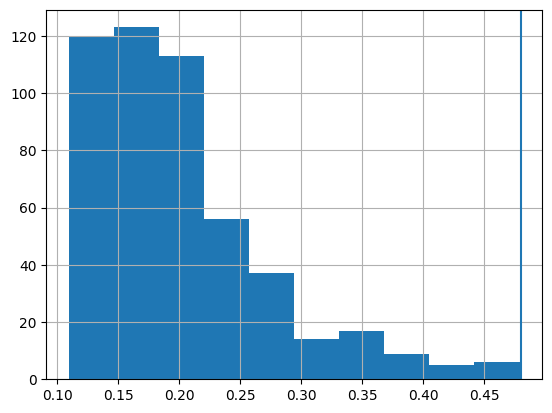

In [14]:
ax = df.silhouette.hist()
ax.axvline(df.best_score.max());

## There is a -ve correlation between Silhouette and DBCV scores for pca/kmeans/silhouette run... this is unexpected, but highllights that optimizing different scores has different effects...

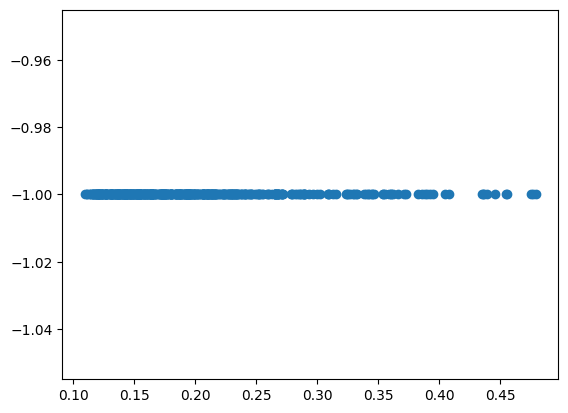

In [15]:
score_1 = 'silhouette'
score_2 = 'dbcv'
plt.scatter(df[score_1], df[score_2])

In [16]:
best_param_cols = sorted([
    col for col in df.columns
    if 'best_params' in col
])

In [17]:
df[best_param_cols]

,best_params.kmeans__init,best_params.kmeans__n_clusters,best_params.kmeans__n_init,best_params.umap__metric,best_params.umap__min_dist,best_params.umap__n_components,best_params.umap__n_neighbors
0,random,10,3,manhattan,0.688568,93,515
1,random,5,1,euclidean,0.055903,155,354
2,random,5,1,euclidean,0.055903,155,354
3,random,5,1,euclidean,0.055903,155,354
4,random,5,1,euclidean,0.055903,155,354
...,...,...,...,...,...,...,...
495,k-means++,2,8,euclidean,0.024850,133,987
496,k-means++,2,8,euclidean,0.024850,133,987
497,k-means++,2,8,euclidean,0.024850,133,987
498,k-means++,2,8,euclidean,0.024850,133,987


##### This plot shows several 'peaks' at different dimensions - are they similar clusterings?

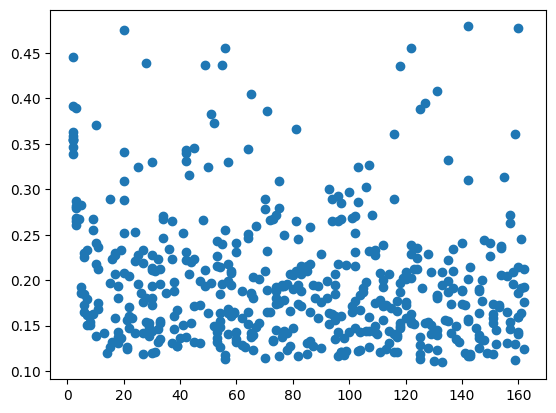

In [19]:
plt.scatter(df['current_params.umap__n_components'], df['silhouette'])
# plt.scatter(df['current_params.pca__n_components'], df['silhouette'])

#### We now fit the same pipeline using the best few parameters:

In [20]:
p_keys = sorted([
    col.split('.')[1] for col in df.columns
    if 'current_params' in col
])

In [21]:
p_keys

['kmeans__init',
 'kmeans__n_clusters',
 'kmeans__n_init',
 'umap__metric',
 'umap__min_dist',
 'umap__n_components',
 'umap__n_neighbors']

In [22]:
def get_params(p_keys, row):

    return {
        p: row['current_params.' + p]
        for p in p_keys
    }

In [91]:
pipe = Pipeline(
        steps=[
            # ('pca', PCA(random_state=run_configs[run_id]['random_seed'])),
            ('umap', umap.UMAP(random_state=run_configs[run_id]['random_seed'])),
            ('kmeans', KMeans(random_state=run_configs[run_id]['random_seed']))
        ]
    )

In [25]:
symptom_data = load_symptom_data(run_configs[run_id]['data_path'])

In [26]:
def cv_score(model, X, score=None, omit_score='rv'):
    """
    If score == 'all' we return a dictionary of all scores, which
    can be logged to wandb on each iteration.

    Otherwise this is intended for use as a scorer in <X>SearchCV methods.
    In that case metric should be fixed to allow comparison across different runs.
    """
    score_dict = SCORE_DICT

    model.fit(X)
    labels = model.steps[1][1].labels_
    data = model.steps[0][1].transform(X)

    if score == 'all':
        return_dict = {
            score_name: score_func(data, labels, model=model)
            for score_name, score_func in score_dict.items()
            if score_name != omit_score
        }
        return_dict.update({'labels': labels})
        return return_dict
    else:
        return score_dict[score](data, labels, model=model)


In [45]:
df_sorted = df.sort_values('silhouette', ascending=False)

In [28]:
scores = {}

In [ ]:
count = 0
for ri,row in tqdm_notebook(df_sorted.iterrows(), total=df_sorted.shape[0]):
    print(count, ri)
    params = get_params(p_keys, row)
    pipe.set_params(**params)
    # fitting done 
    scores[ri] = cv_score(pipe, symptom_data, score='all')
    count += 1 

##### We now compute the similarity between each clustering and the 'best' clustering...

In [16]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

In [31]:
# benchmark_ri = 263  # Currently this is the 'best' scoring clustering, but later could be hand-picked one.
# benchmark_ri = 240  # Currently this is the 'best' scoring clustering, but later could be hand-picked one.
benchmark_ri = 224  # Currently this is the 'best' scoring clustering, but later could be hand-picked one.

In [32]:
for ri in scores.keys():

    similarity = {
        'rand_score': adjusted_rand_score(scores[ri]['labels'], scores[benchmark_ri]['labels']),
        'mi_score': adjusted_mutual_info_score(scores[ri]['labels'], scores[benchmark_ri]['labels'])
    }
    scores[ri].update(similarity)

In [33]:
# with open('./results/%s_scores_and_labels.pickle' % run_name, 'wb') as outfile:
#     pk.dump(scores, outfile)

In [17]:
with open('./results/%s_scores_and_labels.pickle' % run_name, 'rb') as infile:
    scores = pk.load(infile)

##### We now look at the distribution of similarities...
##### And plot similarity vs silhouette - are the higher scoring ones more similar?

In [18]:
all_rand = [
    scores[ri]['rand_score'] for ri in scores.keys()
]
all_mi = [
    scores[ri]['mi_score'] for ri in scores.keys()
]
all_silhouette = [
    scores[ri]['silhouette'] for ri in scores.keys()
]
all_cc = [
    scores[ri]['cluster_count'] for ri in scores.keys()
]

In [19]:
len(scores.keys())
len(all_mi)

500

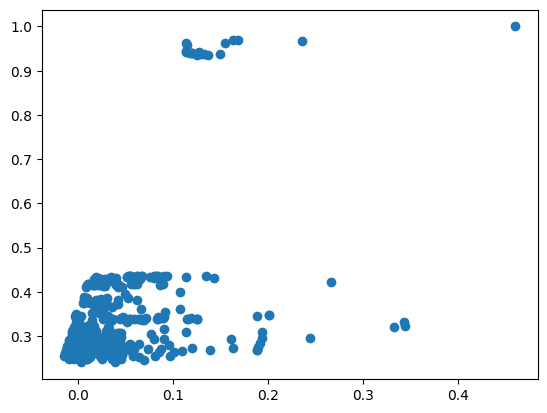

In [20]:
plt.scatter(all_silhouette, all_mi);

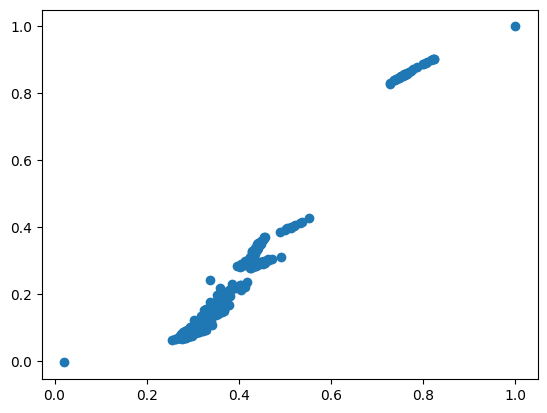

In [27]:
plt.scatter(all_mi, all_rand);

In [28]:
# plt.scatter(all_cc, scores_df.rand_score_with_298);

##### We now produce scatter plots where the points are coloured by their similarity...

In [21]:
test = df_sorted
for ri, row, in test.iterrows():
    print(ri, row)
    break

NameError: name 'df_sorted' is not defined

In [53]:
# scores_df[scores_df.cluster_count==9]

In [48]:
scores[1]

{'silhouette': 0.2555312,
 'dbcv': -1,
 'calinski_harabasz': 4708.495122692847,
 'davies_bouldin': 1.242619000608029,
 'dbcv_minkowski': -0.5842569742948127,
 'fraction_clustered': 1.0,
 'cluster_count': 9,
 'labels': array([1, 2, 1, ..., 2, 7, 4], dtype=int32),
 'rand_score': 0.16715892561654558,
 'mi_score': 0.37678471370950484}

In [52]:
df[df.cluster_count==9]

,best_params.umap__metric,current_params.kmeans__n_clusters,_step,silhouette,_runtime,_timestamp,calinski_harabasz,best_params.kmeans__n_clusters,best_params.kmeans__n_init,best_score,...,current_params.kmeans__init,best_params.umap__n_neighbors,current_params.umap__n_components,current_params.umap__metric,best_params.umap__n_components,current_params.umap__n_neighbors,davies_bouldin,labels,best_params.kmeans__init,dbcv
4,euclidean,9,9,0.254770,1920.532807,1.698129e+09,4709.595045,5,1,0.313310,...,k-means++,354,56,euclidean,155,248,1.239987,"{'_type': 'histogram', 'values': [686, 0, 0, 0...",random,-1
5,manhattan,9,15,0.154076,3097.321404,1.698130e+09,1727.982565,2,3,0.349821,...,k-means++,569,128,euclidean,54,916,1.788266,"{'_type': 'histogram', 'values': [885, 0, 0, 0...",k-means++,-1
13,manhattan,9,39,0.162525,7847.962118,1.698135e+09,1875.780975,2,3,0.349821,...,k-means++,569,9,euclidean,54,904,1.727605,"{'_type': 'histogram', 'values': [744, 0, 0, 0...",k-means++,-1
14,manhattan,9,42,0.163761,8364.176711,1.698135e+09,1783.329164,2,3,0.349821,...,k-means++,569,93,euclidean,54,251,1.845463,"{'_type': 'histogram', 'values': [787, 0, 0, 0...",k-means++,-1
80,euclidean,9,253,0.155757,60473.470063,1.698187e+09,1865.485454,2,6,0.395191,...,random,675,95,euclidean,9,756,1.785834,"{'_type': 'histogram', 'values': [709, 0, 0, 0...",k-means++,-1
158,euclidean,9,501,0.228162,136334.402686,1.698263e+09,3894.714992,2,6,0.460389,...,random,376,25,euclidean,78,367,1.347964,"{'_type': 'histogram', 'values': [547, 0, 0, 0...",k-means++,-1
175,euclidean,9,557,0.139215,153955.797545,1.698281e+09,1444.806513,2,6,0.460389,...,k-means++,376,66,euclidean,78,979,1.905225,"{'_type': 'histogram', 'values': [782, 0, 0, 0...",k-means++,-1
204,euclidean,9,643,0.171536,182130.276329,1.698309e+09,2326.404039,2,6,0.472081,...,k-means++,706,45,manhattan,55,504,1.643390,"{'_type': 'histogram', 'values': [472, 0, 0, 0...",k-means++,-1
205,euclidean,9,648,0.263297,183747.609333,1.698311e+09,4765.915823,2,6,0.472081,...,k-means++,706,157,euclidean,55,94,1.236895,"{'_type': 'histogram', 'values': [586, 0, 0, 0...",k-means++,-1
207,euclidean,9,654,0.166943,185755.106486,1.698313e+09,2011.727576,2,6,0.472081,...,random,706,104,manhattan,55,328,1.708382,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",k-means++,-1


In [54]:
n_cpts = [
    df.iloc[ri]['current_params.pca__n_components']
    for ri in scores.keys()
]
# all_silhouette = [
#     df.loc[ri]['silhouette']
#     for ri in scores.keys()
# ]

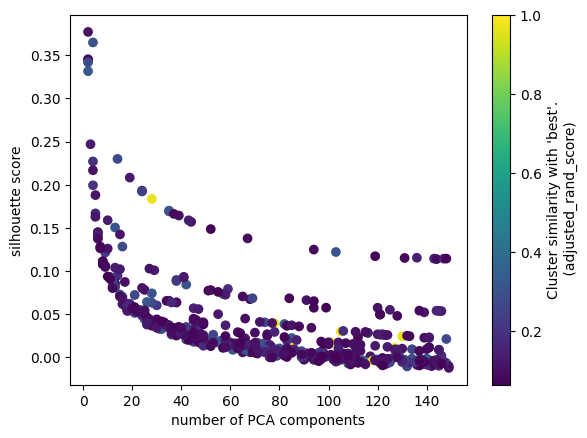

In [55]:
plt.scatter(n_cpts, all_silhouette, c=all_rand)
cbar = plt.colorbar(label="Cluster similarity with 'best'.\n (adjusted_rand_score)")
plt.xlabel('number of PCA components');
plt.ylabel('silhouette score');

In [42]:
n_cpts = [
    df.iloc[ri]['current_params.umap__n_components']
    for ri in scores.keys()
]

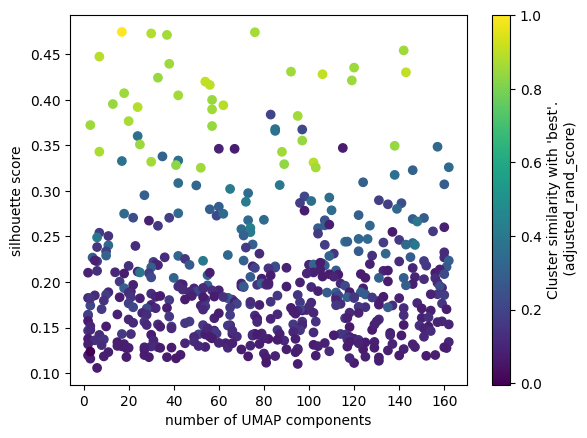

In [43]:
plt.scatter(n_cpts, all_silhouette, c=all_rand)
cbar = plt.colorbar(label="Cluster similarity with 'best'.\n (adjusted_rand_score)")
plt.xlabel('number of UMAP components');
plt.ylabel('silhouette score');

In [36]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')

In [64]:
scores_df.sort_values('silhouette', ascending=False).iloc[0].name

224

In [37]:
SCORE_DICT = {
        'silhouette': silhouette,
        'dbcv': dbcv,
        'calinski_harabasz': calinski_harabasz,
        'davies_bouldin': davies_bouldin,
        'dbcv_minkowski': dbcv_minkowski,
        'cluster_count': cluster_count
}

##### The following score correlations are as expected, except perhaps dbcv_minkowski.

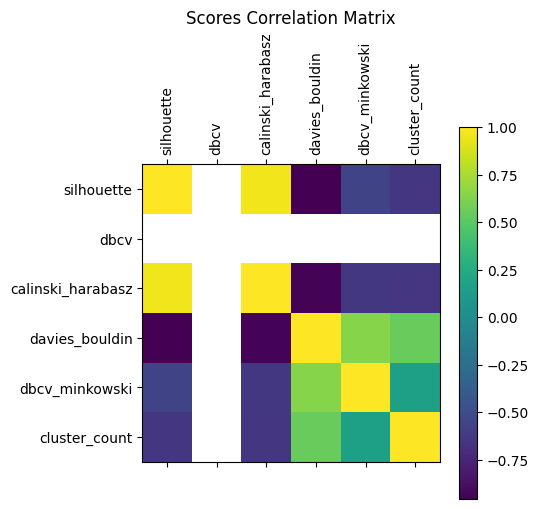

In [38]:
plt.matshow(scores_df[SCORE_DICT.keys()].corr())
plt.xticks(ticks=range(len(SCORE_DICT)), labels=SCORE_DICT.keys(), rotation=90)
plt.yticks(ticks=range(len(SCORE_DICT)), labels=SCORE_DICT.keys(), rotation=0)
plt.colorbar()
plt.title('Scores Correlation Matrix', fontsize=12);

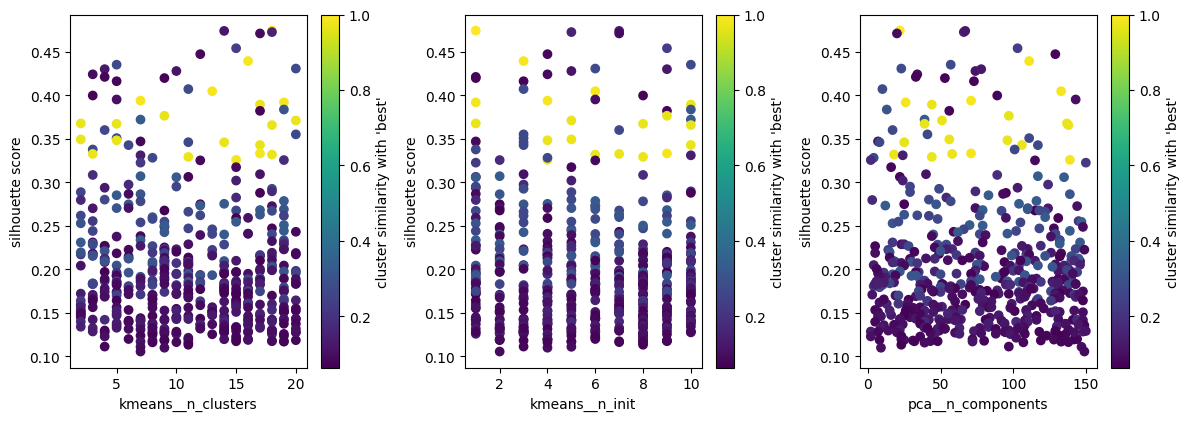

In [169]:
pi = 1
plt.figure(figsize=(12,8))
for param in p_keys:
    if param != 'kmeans__init':
        plt.subplot(2,3,pi)

        X = [
            df.iloc[ri]['current_params.' + param]
            for ri in scores_df.index
        ]
        # plt.scatter(X, all_silhouette, c=all_rand)
        plt.scatter(X, all_silhouette, c=scores_df.rand_score)
        # plt.scatter(X, all_silhouette, c=scores_df.rand_score_with_279)
        cbar = plt.colorbar(label="cluster similarity with 'best'")
        plt.xlabel(param);
        plt.ylabel('silhouette score');
        pi += 1

plt.tight_layout()
# plt.savefig('./results/plots/partial_dependence_silhouette_color_adj_rand_279_%s.png' % run_name)

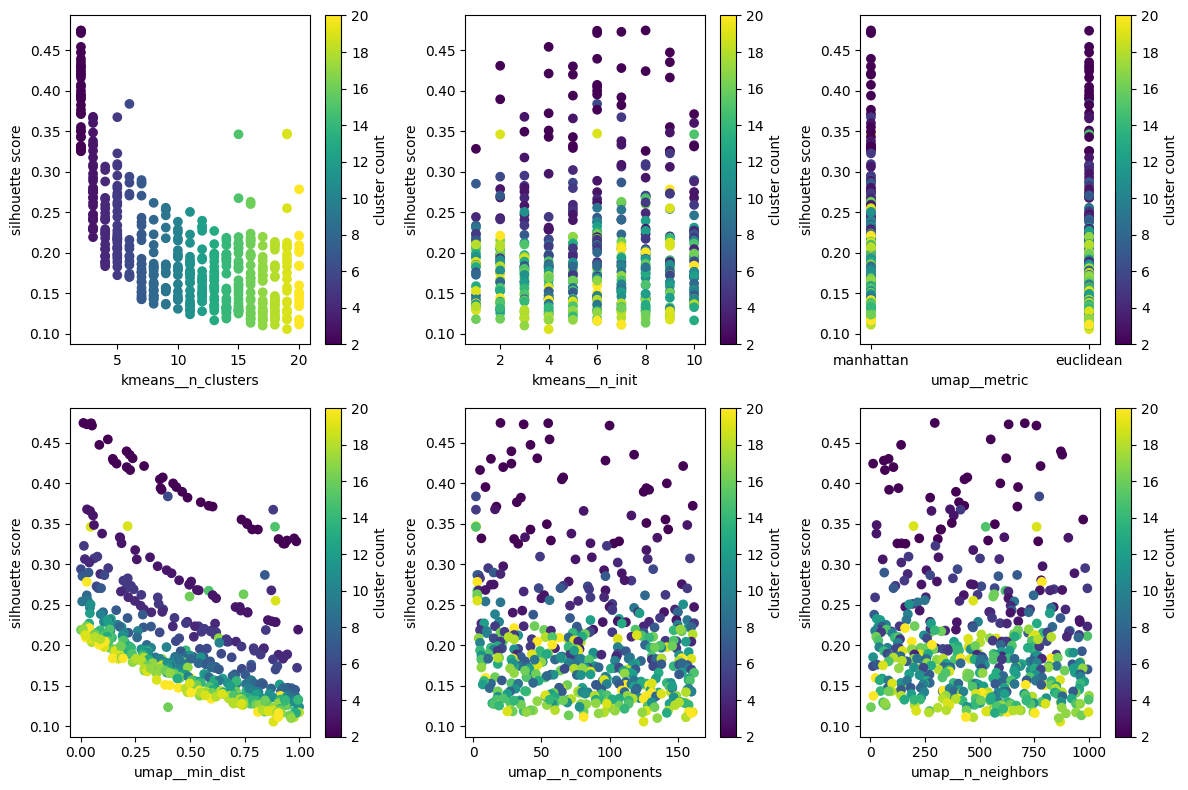

In [95]:
pi = 1
plt.figure(figsize=(12,8))
for param in p_keys:
    if param != 'kmeans__init':
        plt.subplot(2,3,pi)

        X = [
            df.iloc[ri]['current_params.' + param]
            for ri in scores.keys()
        ]
        plt.scatter(X, all_silhouette, c=all_cc)
        cbar = plt.colorbar(label="cluster count")
        plt.xlabel(param);
        plt.ylabel('silhouette score');
        pi += 1

plt.tight_layout()
# plt.savefig('./results/plots/partial_dependence_silhouette_color_cluster_count_%s.png' % run_name)

### We are seeing similar clusterings with two clusters pop up...

In [49]:
len(scores[224]['labels'])

6031

In [50]:
sum(scores[224]['labels'])

2073

In [51]:
with open('./results/pca_kmeans_silhouette_run_0_randomized_scores_and_labels.pickle', 'rb') as outfile:
    pca_scores = pk.load(outfile)

In [54]:
sum(pca_scores[263]['labels'])

3674

In [55]:
adjusted_mutual_info_score(pca_scores[263]['labels'], scores[224]['labels'])

0.5090797304156585

In [56]:
adjusted_rand_score(pca_scores[263]['labels'], scores[224]['labels'])

0.6218944630886261

### The best clustering (silhouette) with 6 clusters looks interesting as it stands out above other silhouette scores at that # clusters. Lets investigate...

(There  are also candidates at 5, 15, 19 clusters).

In [68]:
scores_df.cluster_count.unique()

array([ 2,  6,  3,  5, 19, 15,  4,  7, 20, 16,  8,  9, 12, 11, 10, 13, 14,
       18, 17])

In [114]:
scores_df[scores_df.cluster_count == 5].sort_values('silhouette', ascending=False).iloc[0]

silhouette                                                      0.367279
dbcv                                                                  -1
calinski_harabasz                                            6361.771152
davies_bouldin                                                  0.862612
dbcv_minkowski                                                 -0.699049
fraction_clustered                                                   1.0
cluster_count                                                          5
labels                 [2, 2, 4, 0, 3, 0, 3, 0, 2, 3, 4, 0, 1, 0, 1, ...
rand_score                                                       0.21724
mi_score                                                        0.358881
rand_score_with_298                                             0.608978
Name: 279, dtype: object

In [131]:
benchmark_ri = 279

scores_df['rand_score_with_%d' % benchmark_ri] = [
    adjusted_rand_score(scores[ri]['labels'], scores[benchmark_ri]['labels'])
    for ri in scores.keys()
]
scores_df['mi_score_with_%d' % benchmark_ri] = [
    adjusted_mutual_info_score(scores[ri]['labels'], scores[benchmark_ri]['labels'])
    for ri in scores.keys()
]

In [132]:
scores_df.loc[298]

silhouette                                                      0.383661
dbcv                                                                  -1
calinski_harabasz                                            7371.365568
davies_bouldin                                                  0.802155
dbcv_minkowski                                                 -0.658099
fraction_clustered                                                   1.0
cluster_count                                                          6
labels                 [5, 0, 5, 2, 4, 2, 4, 2, 5, 4, 1, 2, 3, 0, 0, ...
rand_score                                                      0.198763
mi_score                                                        0.352755
rand_score_with_298                                                  1.0
rand_score_with_279                                             0.543965
mi_score_with_279                                               0.608978
Name: 298, dtype: object

##### Interestingly the 5 and 6 cluster strucutres with high silhouette scores are quite disimilar from each other and all other clusterings...

In [123]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

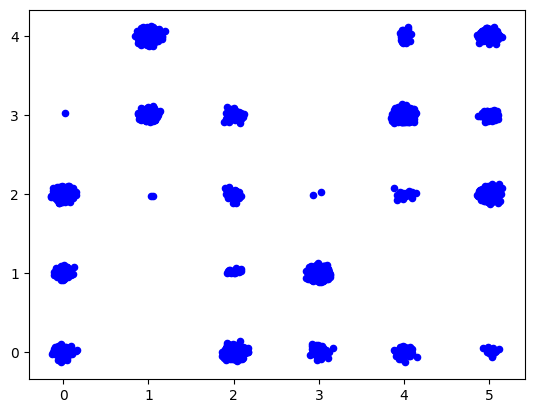

In [128]:
jitter(scores_df.loc[298].labels, scores_df.loc[279].labels);

In [89]:
scores_df.to_csv('./results/%s_processed_scores_and_labels.csv' % run_name)

In [92]:
with open('./test_results.pickle', 'wb') as outfile:
    pk.dump(scores_df, outfile)

In [63]:
with open('./results/pca_kmeans_silhouette_run_0_randomized/scores_and_labels_df.pickle', 'rb') as infile:
    test = pk.load(infile)

In [70]:
scores_df.loc[263]

silhouette                                                     0.460445
dbcv                                                          -0.830713
calinski_harabasz                                           7299.650321
davies_bouldin                                                 0.814748
dbcv_minkowski                                                -0.830713
fraction_clustered                                                  1.0
cluster_count                                                         2
labels                [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...
rand_score                                                          1.0
mi_score                                                            1.0
Name: 263, dtype: object

In [67]:
scores_df

,silhouette,dbcv,calinski_harabasz,davies_bouldin,dbcv_minkowski,fraction_clustered,cluster_count,labels,rand_score,mi_score
263,0.460445,-0.830713,7299.650321,0.814748,-0.830713,1.0,2,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...",1.000000,1.000000
314,0.344999,-0.699427,6094.782857,0.857790,-0.699427,1.0,9,"[6, 5, 7, 2, 0, 4, 0, 4, 8, 0, 6, 4, 2, 3, 3, ...",0.153408,0.321318
320,0.343635,-0.638892,6109.412883,0.813603,-0.638892,1.0,13,"[1, 6, 4, 7, 7, 0, 7, 0, 10, 7, 11, 0, 12, 2, ...",0.121303,0.332148
394,0.333391,-0.559132,5927.225301,0.832505,-0.559132,1.0,18,"[14, 16, 2, 15, 15, 4, 15, 11, 6, 11, 14, 11, ...",0.092044,0.320387
325,0.266400,-0.685177,3430.881271,1.127907,-0.685177,1.0,7,"[2, 6, 4, 3, 0, 4, 0, 3, 6, 4, 2, 3, 0, 0, 5, ...",0.234367,0.421406
...,...,...,...,...,...,...,...,...,...,...
231,-0.010623,-0.322181,90.225171,5.153296,-0.322181,1.0,16,"[8, 10, 4, 9, 4, 4, 4, 5, 10, 1, 8, 11, 15, 5,...",0.089761,0.275162
69,-0.010885,-0.332608,102.393763,5.189198,-0.332608,1.0,14,"[13, 0, 8, 6, 12, 12, 12, 4, 0, 12, 10, 12, 9,...",0.096806,0.276411
337,-0.012018,-0.317215,74.743990,5.186964,-0.317215,1.0,20,"[1, 5, 10, 0, 19, 10, 19, 0, 5, 19, 9, 0, 7, 2...",0.077164,0.268131
208,-0.013144,-0.319267,75.625025,5.197379,-0.319267,1.0,20,"[9, 5, 9, 6, 6, 19, 14, 1, 18, 6, 4, 8, 17, 1,...",0.076249,0.261067


In [65]:
df.loc[1]

_runtime                                                                     87.388638
silhouette                                                                     0.00979
current_params.pca__n_components                                                    92
best_params.pca__n_components                                                       92
best_params.kmeans__n_clusters                                                       8
davies_bouldin                                                                4.661691
dbcv                                                                         -0.373172
labels                               {'packedBins': {'min': 0, 'size': 0.21875, 'co...
_timestamp                                                           1698127173.270448
current_params.kmeans__init                                                  k-means++
dbcv_minkowski                                                               -0.373172
best_params.kmeans__init                   

In [34]:
df[df.cluster_count==9]

,_runtime,silhouette,current_params.pca__n_components,best_params.pca__n_components,best_params.kmeans__n_clusters,davies_bouldin,dbcv,labels,_timestamp,current_params.kmeans__init,dbcv_minkowski,best_params.kmeans__init,current_params.kmeans__n_clusters,calinski_harabasz,best_params.kmeans__n_init,cluster_count,_step,best_score,current_params.kmeans__n_init
4,2880.483010,0.102377,9,2,19,2.122677,-0.520482,"{'packedBins': {'count': 32, 'min': 0, 'size':...",1.698130e+09,k-means++,-0.520482,random,9,864.858671,6,9,110,0.330836,9
26,14257.297646,0.144332,6,3,2,1.696794,-0.560642,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698141e+09,k-means++,-0.560642,k-means++,9,1293.221758,4,9,494,0.404479,7
33,21162.760912,0.002862,115,3,2,4.918708,-0.355086,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698148e+09,random,-0.355086,k-means++,9,164.533880,4,9,705,0.404479,2
52,24674.699957,0.051379,25,3,2,3.051395,-0.430837,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698152e+09,k-means++,-0.430837,k-means++,9,412.100444,4,9,848,0.404479,7
56,27401.163375,0.063295,20,3,2,2.872962,-0.454451,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698154e+09,k-means++,-0.454451,k-means++,9,478.130912,4,9,909,0.404479,3
82,43411.702278,0.012250,80,3,2,4.470386,-0.345851,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698170e+09,k-means++,-0.345851,k-means++,9,198.511749,4,9,1255,0.404479,1
83,43989.522170,0.051431,26,3,2,3.135268,-0.397264,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698171e+09,random,-0.397264,k-means++,9,400.752532,4,9,1266,0.404479,4
103,64475.597265,0.026583,48,3,2,3.759569,-0.366628,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698192e+09,k-means++,-0.366628,k-means++,9,270.342521,4,9,1716,0.404479,6
126,92699.798778,0.090256,11,3,2,2.317693,-0.502254,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698220e+09,random,-0.502254,k-means++,9,736.583096,4,9,2219,0.404479,8
230,194120.460507,0.057834,21,2,2,2.872894,-0.450654,"{'packedBins': {'min': 0, 'size': 0.25, 'count...",1.698321e+09,random,-0.450654,k-means++,9,463.928251,4,9,4024,0.460445,3


In [29]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')

In [30]:
scores_df

,silhouette,dbcv,calinski_harabasz,davies_bouldin,dbcv_minkowski,fraction_clustered,cluster_count,labels,rand_score,mi_score
263,0.460445,-0.830713,7299.650321,0.814748,-0.830713,1.0,2,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...",1.000000,1.000000
314,0.344999,-0.699427,6094.782857,0.857790,-0.699427,1.0,9,"[6, 5, 7, 2, 0, 4, 0, 4, 8, 0, 6, 4, 2, 3, 3, ...",0.153408,0.321318
320,0.343635,-0.638892,6109.412883,0.813603,-0.638892,1.0,13,"[1, 6, 4, 7, 7, 0, 7, 0, 10, 7, 11, 0, 12, 2, ...",0.121303,0.332148
394,0.333391,-0.559132,5927.225301,0.832505,-0.559132,1.0,18,"[14, 16, 2, 15, 15, 4, 15, 11, 6, 11, 14, 11, ...",0.092044,0.320387
325,0.266400,-0.685177,3430.881271,1.127907,-0.685177,1.0,7,"[2, 6, 4, 3, 0, 4, 0, 3, 6, 4, 2, 3, 0, 0, 5, ...",0.234367,0.421406
...,...,...,...,...,...,...,...,...,...,...
231,-0.010623,-0.322181,90.225171,5.153296,-0.322181,1.0,16,"[8, 10, 4, 9, 4, 4, 4, 5, 10, 1, 8, 11, 15, 5,...",0.089761,0.275162
69,-0.010885,-0.332608,102.393763,5.189198,-0.332608,1.0,14,"[13, 0, 8, 6, 12, 12, 12, 4, 0, 12, 10, 12, 9,...",0.096806,0.276411
337,-0.012018,-0.317215,74.743990,5.186964,-0.317215,1.0,20,"[1, 5, 10, 0, 19, 10, 19, 0, 5, 19, 9, 0, 7, 2...",0.077164,0.268131
208,-0.013144,-0.319267,75.625025,5.197379,-0.319267,1.0,20,"[9, 5, 9, 6, 6, 19, 14, 1, 18, 6, 4, 8, 17, 1,...",0.076249,0.261067


#### And we produce 2D visualisation of some similar and dissimilar clusterings...

##### Using 2D embedding or first 2 dimensions of the clustering embedding?

##### We now compare the best clusterings for each run - how similar are they?